<a href="https://colab.research.google.com/github/sidravic/detectron_object_detection/blob/master/Detectron2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q cython pyyaml==5.1 

!pip install -q -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

     |████████████████████████████████| 276kB 8.5MB/s 


In [2]:
! ls -l -a

total 16
drwxr-xr-x 1 root root 4096 May 29 18:19 .
drwxr-xr-x 1 root root 4096 Jun  7 13:35 ..
drwxr-xr-x 1 root root 4096 Jun  2 16:14 .config
drwxr-xr-x 1 root root 4096 May 29 18:19 sample_data


In [3]:
 !git clone https://github.com/facebookresearch/detectron2 detectron2_repo 
 !pip install -q -e detectron2_repo

Cloning into 'detectron2_repo'...
remote: Enumerating objects: 5352, done.
remote: Total 5352 (delta 0), reused 0 (delta 0), pack-reused 5352
Receiving objects: 100% (5352/5352), 2.51 MiB | 4.38 MiB/s, done.
Resolving deltas: 100% (3845/3845), done.


In [4]:
! pip install fastai

In [0]:
import torch, torchvision
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.structures import BoxMode
from detectron2.evaluation import COCOEvaluator

In [2]:
import glob
import os
import ntpath
import numpy as np

import cv2
import random
import itertools
import pandas as pd
from tqdm import tqdm
import urllib
import json
import PIL.Image as Image


import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [0]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE =  ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE)) 
rcParams['figure.figsize'] = 12, 8 

In [5]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [6]:
 !gdown --id 1K79wJgmPTWamqb04Op2GxW0SW9oxw8KS


Downloading...
From: https://drive.google.com/uc?id=1K79wJgmPTWamqb04Op2GxW0SW9oxw8KS
To: /content/face_detection.json
100% 274k/274k [00:00<00:00, 82.2MB/s]


In [7]:
ls -l -a

total 288
drwxr-xr-x  1 root root   4096 Jun  7 14:03 ./
drwxr-xr-x  1 root root   4096 Jun  7 13:35 ../
drwxr-xr-x  1 root root   4096 Jun  2 16:14 .config/
drwxr-xr-x 17 root root   4096 Jun  7 13:39 detectron2_repo/
-rw-r--r--  1 root root 273830 Jun  7 14:03 face_detection.json
drwxr-xr-x  1 root root   4096 May 29 18:19 sample_data/


In [8]:
faces_df = pd.read_json('face_detection.json', lines=True); faces_df

content  ... extras
0    http://com.dataturks.a96-i23.open.s3.amazonaws...  ...    NaN
1    http://com.dataturks.a96-i23.open.s3.amazonaws...  ...    NaN
2    http://com.dataturks.a96-i23.open.s3.amazonaws...  ...    NaN
3    http://com.dataturks.a96-i23.open.s3.amazonaws...  ...    NaN
4    http://com.dataturks.a96-i23.open.s3.amazonaws...  ...    NaN
..                                                 ...  ...    ...
404  http://com.dataturks.a96-i23.open.s3.amazonaws...  ...    NaN
405  http://com.dataturks.a96-i23.open.s3.amazonaws...  ...    NaN
406  http://com.dataturks.a96-i23.open.s3.amazonaws...  ...    NaN
407  http://com.dataturks.a96-i23.open.s3.amazonaws...  ...    NaN
408  http://com.dataturks.a96-i23.open.s3.amazonaws...  ...    NaN

[409 rows x 3 columns]

In [9]:
faces_df.iloc[1]['annotation']

[{'imageHeight': 697,
  'imageWidth': 1280,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.70530877573131, 'y': 0.23260437375745502},
   {'x': 0.769230769230769, 'y': 0.36182902584493004}]}]

In [10]:
faces_df.iloc[2]['annotation']

[{'imageHeight': 240,
  'imageWidth': 460,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.469565217391304, 'y': 0.05},
   {'x': 0.6065217391304341, 'y': 0.33333333333333304}]},
 {'imageHeight': 240,
  'imageWidth': 460,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.6282608695652171, 'y': 0.008333333333333},
   {'x': 0.7456521739130431, 'y': 0.308333333333333}]}]

In [11]:
faces_df.loc[408]

content       http://com.dataturks.a96-i23.open.s3.amazonaws...
annotation    [{'label': ['Face'], 'notes': '', 'points': [{...
extras                                                      NaN
Name: 408, dtype: object

### Create a directory for faces

In [12]:
! ls -l -a

total 288
drwxr-xr-x  1 root root   4096 Jun  7 14:03 .
drwxr-xr-x  1 root root   4096 Jun  7 13:35 ..
drwxr-xr-x  1 root root   4096 Jun  2 16:14 .config
drwxr-xr-x 17 root root   4096 Jun  7 13:39 detectron2_repo
-rw-r--r--  1 root root 273830 Jun  7 14:03 face_detection.json
drwxr-xr-x  1 root root   4096 May 29 18:19 sample_data


In [0]:
from fastai.core import Path

In [0]:
ROOT_PATH = Path('.')
DATA_PATH = Path(ROOT_PATH/'data')
DATA_PATH.mkdir(parents=False, exist_ok=True)

In [0]:
FACES_PATH = Path(DATA_PATH/'faces')
FACES_PATH.mkdir(parents=False, exist_ok=True)
FACES_PATH.ls()

ANNOTATIONS_PATH = Path(DATA_PATH/'annotations.csv')

In [16]:
dataset = []

def int_round(v): return int(round(v))

for index, row in tqdm(faces_df.iterrows(), total=faces_df.shape[0]):
  img = urllib.request.urlopen(row['content'])
  img = Image.open(img)
  img = img.convert('RGB')

  image_name = f'face_{index}.jpeg'
  image_path = Path(FACES_PATH/f'{image_name}')
  img.save(image_path)

  annotations = row['annotation']
  for an in annotations:
    data = {}
    width, height, points = an['imageWidth'], an['imageHeight'], an['points']
    data['file_name'] = image_name
    data['width'] = width
    data['height'] = height

    data['x_min'] = int_round(points[0]['x'] * width )
    data['y_min'] = int_round(points[0]['y'] * height)
    data['x_max'] = int_round(points[1]['x'] * width )    
    data['y_max'] = int_round(points[1]['y'] * height)

    data['class_name'] = 'face'
    dataset.append(data)

100%|██████████| 409/409 [03:53<00:00,  1.75it/s]


In [0]:
df = pd.DataFrame(dataset)

In [18]:
df.head()

file_name  width  height  x_min  y_min  x_max  y_max class_name
0  face_0.jpeg    650     333     56    102    112    151       face
1  face_0.jpeg    650     333    379     97    428    156       face
2  face_1.jpeg   1280     697    903    162    985    252       face
3  face_2.jpeg    460     240    216     12    279     80       face
4  face_2.jpeg    460     240    289      2    343     74       face

In [19]:
df.file_name.shape

(1132,)

In [0]:
df.to_csv(ANNOTATIONS_PATH, header=True, index=None)

In [21]:
DATA_PATH.ls()

[PosixPath('data/annotations.csv'), PosixPath('data/faces')]

### Annotate the images. Add bounding boxes and Resize

In [22]:
annotations[:3]

[{'imageHeight': 493,
  'imageWidth': 656,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.32012195121951204, 'y': 0.28397565922920803},
   {'x': 0.40091463414634104, 'y': 0.41987829614604405}]},
 {'imageHeight': 493,
  'imageWidth': 656,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.45579268292682906, 'y': 0.38742393509127704},
   {'x': 0.54420731707317, 'y': 0.5618661257606491}]},
 {'imageHeight': 493,
  'imageWidth': 656,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.6707317073170731, 'y': 0.38336713995943206},
   {'x': 0.7134146341463411, 'y': 0.474645030425963}]}]

In [0]:
def annotate_image(annotations, resize=True, debug=False):
  file_name = annotations.file_name.to_numpy()[0]
  
  if debug: print(f'Filename: {file_name}')
  img_path = str(FACES_PATH/f'{file_name}')
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  for i, a in annotations.iterrows():
    cv2.rectangle(img, (a.x_min, a.y_min), (a.x_max, a.y_max), (0, 255, 0), 2)
  
  if not resize: return img

  return cv2.resize(img, (384, 384), interpolation = cv2.INTER_AREA)

def show_image_with_annotation(annotation_df, resize=False):
   img = annotate_image(annotation_df, resize=resize)
   plt.imshow(img)
   plt.axis('off')

def show_image_grid(images_df, debug=False):
  sample_images = [annotate_image(df[df.file_name == f])  for f in df.file_name.unique()[:10]]
  sample_images = torch.as_tensor(sample_images)
  if debug: print(f'[show_image_grid]: image.shape: {sample_images.shape}')
  sample_images = sample_images.permute(0, 3, 1, 2)
  plt.figure(figsize=(24, 12))
  grid_img = torchvision.utils.make_grid(sample_images, nrow=5)
  if debug: print(f'[show_image_grid]: grid_img.shape: {grid_img.shape}' )
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off')





In [24]:
img_df = df[df.file_name == df.file_name.unique()[0]]; img_df

file_name  width  height  x_min  y_min  x_max  y_max class_name
0  face_0.jpeg    650     333     56    102    112    151       face
1  face_0.jpeg    650     333    379     97    428    156       face

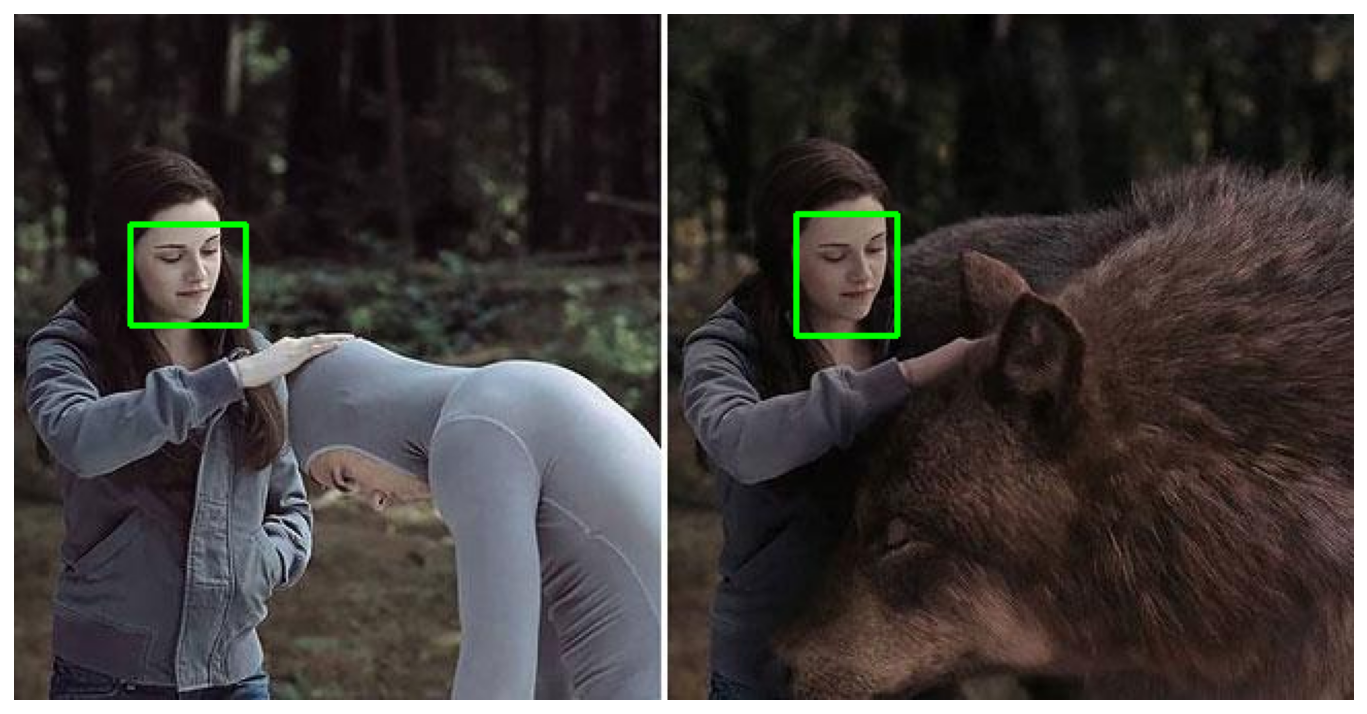

In [25]:
show_image_with_annotation(img_df)

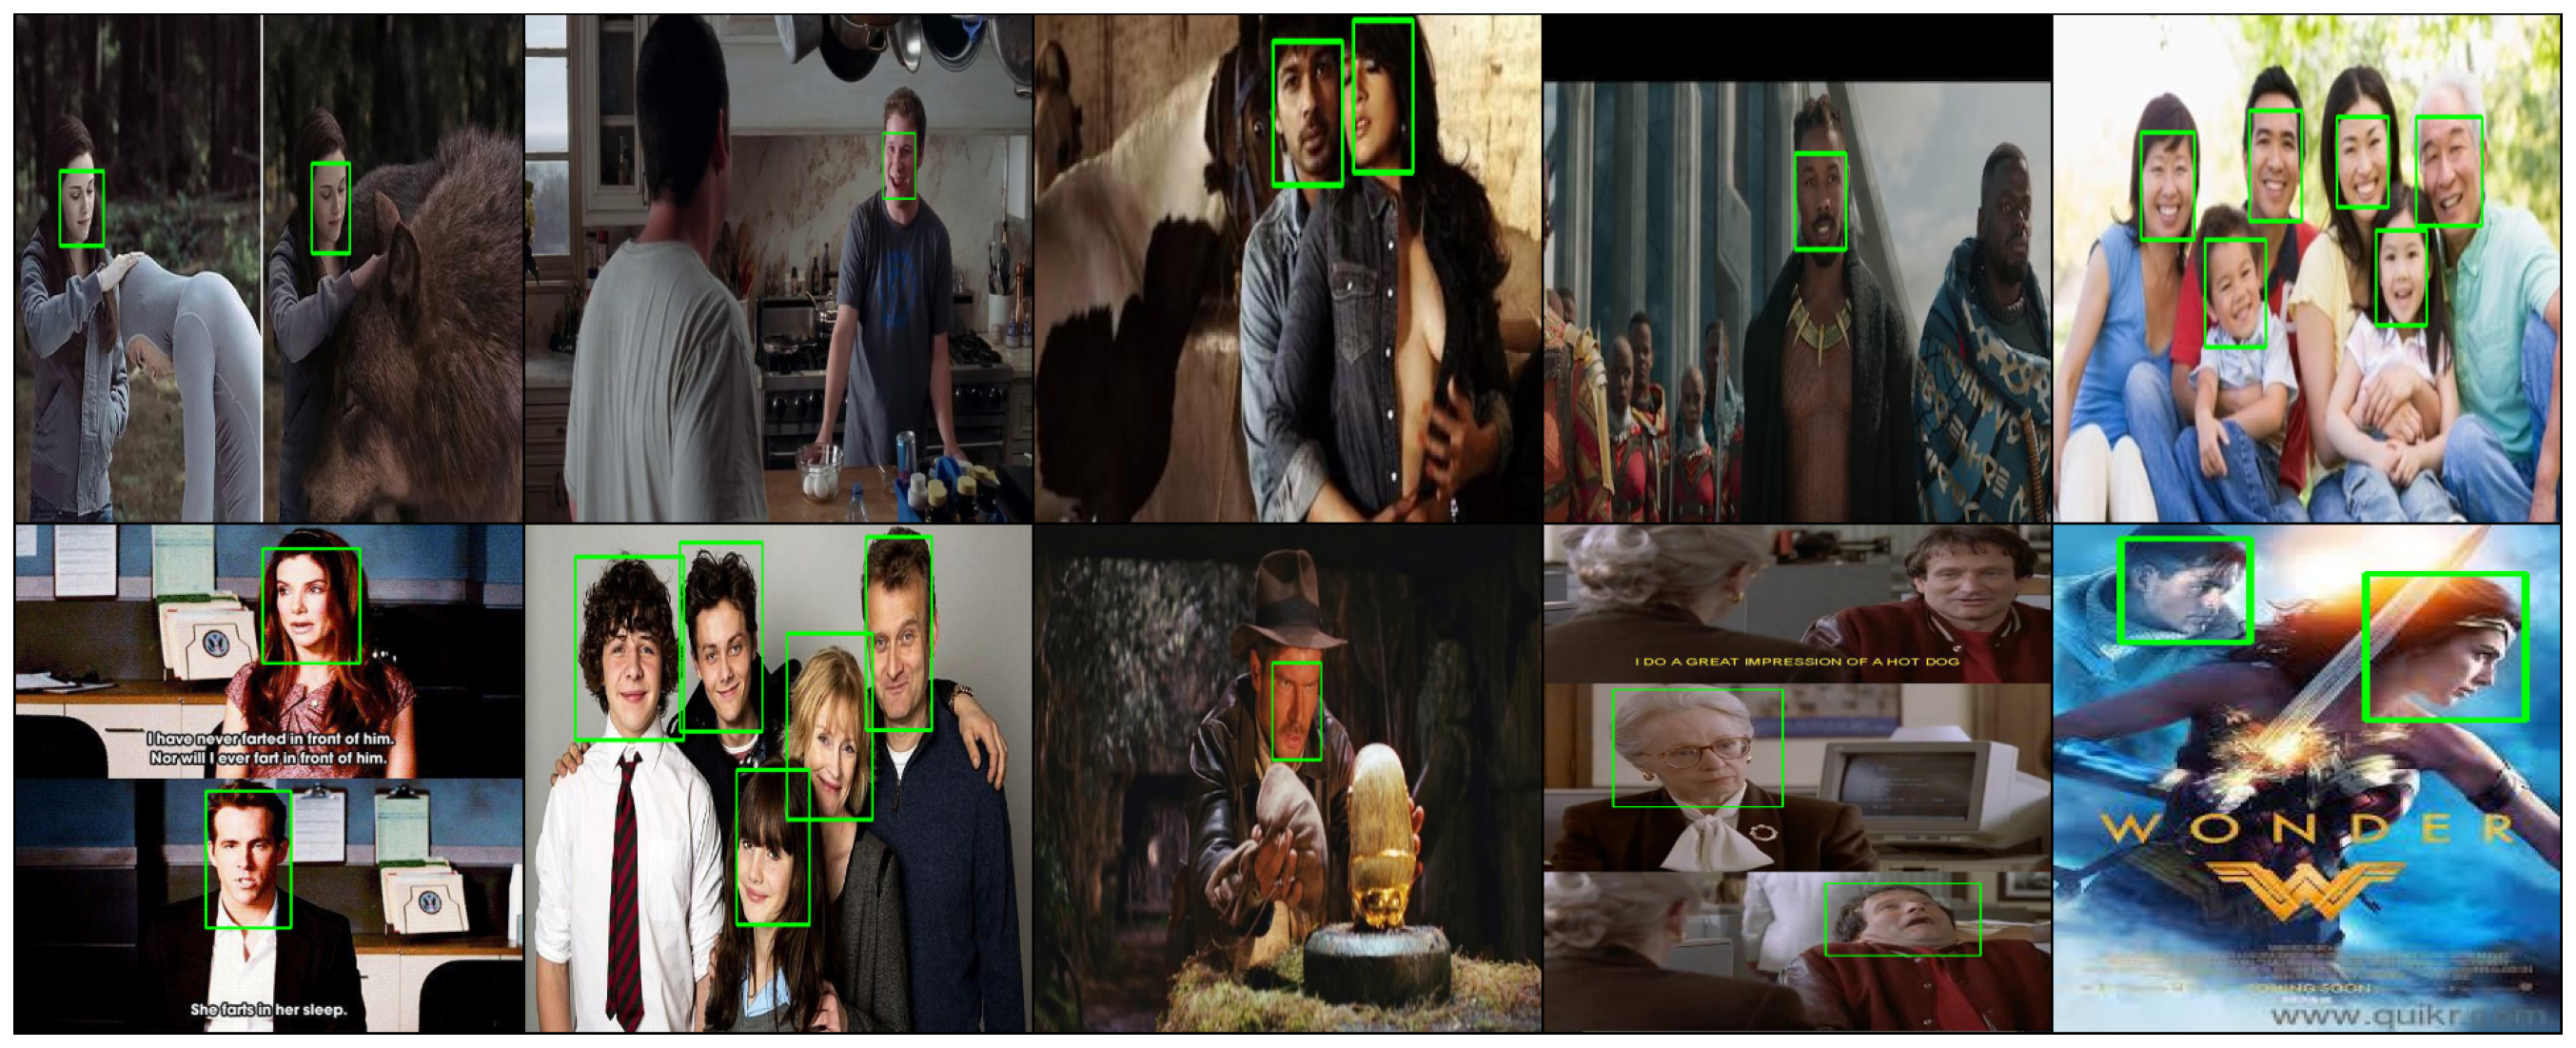

In [26]:
show_image_grid(df)

### Create training and test datasets

In [0]:
df = pd.read_csv(DATA_PATH/'annotations.csv')

In [28]:
df.head()

file_name  width  height  x_min  y_min  x_max  y_max class_name
0  face_0.jpeg    650     333     56    102    112    151       face
1  face_0.jpeg    650     333    379     97    428    156       face
2  face_1.jpeg   1280     697    903    162    985    252       face
3  face_2.jpeg    460     240    216     12    279     80       face
4  face_2.jpeg    460     240    289      2    343     74       face

1. Find all the unique file names
2. Select 95% of the files for training and reservce 5% for testing


In [0]:
unique_files = df.file_name.unique()

In [30]:
train_files = np.random.choice(unique_files, int(len(unique_files) * 0.95 ), replace=False)
train_files[:10]

array(['face_172.jpeg', 'face_137.jpeg', 'face_126.jpeg', 'face_94.jpeg', 'face_72.jpeg', 'face_33.jpeg',
       'face_379.jpeg', 'face_223.jpeg', 'face_341.jpeg', 'face_227.jpeg'], dtype=object)

In [31]:
train_df = df[df.file_name.isin(train_files)]
test_df = df[~df.file_name.isin(train_files)]

train_df.head()

file_name  width  height  x_min  y_min  x_max  y_max class_name
0  face_0.jpeg    650     333     56    102    112    151       face
1  face_0.jpeg    650     333    379     97    428    156       face
2  face_1.jpeg   1280     697    903    162    985    252       face
3  face_2.jpeg    460     240    216     12    279     80       face
4  face_2.jpeg    460     240    289      2    343     74       face

In [32]:
test_df.head()

file_name  width  height  x_min  y_min  x_max  y_max class_name
50   face_20.jpeg    480     360    239     75    377    248       face
182  face_71.jpeg    425     282     32     33    112    123       face
183  face_71.jpeg    425     282    111     89    163    166       face
184  face_71.jpeg    425     282    159     33    210    113       face
185  face_71.jpeg    425     282    214     53    274    129       face

In [33]:
classes = df.class_name.unique().tolist(); classes

['face']

### Convert into detectron2 dataset format

In [34]:
classes, df

(['face'],
           file_name  width  height  x_min  y_min  x_max  y_max class_name
 0       face_0.jpeg    650     333     56    102    112    151       face
 1       face_0.jpeg    650     333    379     97    428    156       face
 2       face_1.jpeg   1280     697    903    162    985    252       face
 3       face_2.jpeg    460     240    216     12    279     80       face
 4       face_2.jpeg    460     240    289      2    343     74       face
 ...             ...    ...     ...    ...    ...    ...    ...        ...
 1127  face_408.jpeg    656     493    164    122    187    150       face
 1128  face_408.jpeg    656     493    318    115    346    159       face
 1129  face_408.jpeg    656     493    389    156    407    177       face
 1130  face_408.jpeg    656     493    507    204    526    226       face
 1131  face_408.jpeg    656     493    527    254    558    309       face
 
 [1132 rows x 8 columns])

In [0]:
def create_dataset_dict(df, classes, debug=False):
  datasets_dict = []

  for image_id, img_name in enumerate(df.file_name.unique()):
    record = {}

    image_df = df[df.file_name == img_name]
    if debug: print(image_df)

    file_path = FACES_PATH/f'{img_name}'
    if debug: print(f'file_path: {file_path}')

    record['file_name'] = str(file_path)
    record['image_id'] = image_id
    record['height'] = int(image_df.iloc[0].height)
    record['width'] = int(image_df.iloc[0].width)

    objs= []

    for _, row in image_df.iterrows():

      xmin = int(row.x_min)
      ymin = int(row.y_min)
      xmax = int(row.x_max)
      ymax = int(row.y_max)

      poly = [
              (xmin, ymin), (xmax, ymin),
              (xmax, ymax), (xmin, ymax)
      ]

      poly = list(itertools.chain.from_iterable(poly))

      obj = {
          'bbox': [xmin, ymin, xmax, ymax],
          'bbox_mode': BoxMode.XYXY_ABS,
          'segmentation': [poly],
          'category_id': classes.index(row.class_name),
          'iscrowd': 0
      }

      objs.append(obj)
      record['annotations'] = objs
      datasets_dict.append(record)
  return datasets_dict



In [52]:
d = create_dataset_dict(train_df, classes)
d[:5]

[{'annotations': [{'bbox': [56, 102, 112, 151],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 0,
    'iscrowd': 0,
    'segmentation': [[56, 102, 112, 102, 112, 151, 56, 151]]},
   {'bbox': [379, 97, 428, 156],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 0,
    'iscrowd': 0,
    'segmentation': [[379, 97, 428, 97, 428, 156, 379, 156]]}],
  'file_name': 'data/faces/face_0.jpeg',
  'height': 333,
  'image_id': 0,
  'width': 650},
 {'annotations': [{'bbox': [56, 102, 112, 151],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 0,
    'iscrowd': 0,
    'segmentation': [[56, 102, 112, 102, 112, 151, 56, 151]]},
   {'bbox': [379, 97, 428, 156],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 0,
    'iscrowd': 0,
    'segmentation': [[379, 97, 428, 97, 428, 156, 379, 156]]}],
  'file_name': 'data/faces/face_0.jpeg',
  'height': 333,
  'image_id': 0,
  'width': 650},
 {'annotations': [{'bbox': [903, 162, 985, 252],
    'bbox_mode': <BoxMode.XYXY_

In [53]:
print(len(train_df.file_name.unique()))
! pwd


388
/content


### DatasetCatalog

The `DatasetCatalog` is a Detectron's class used to tell it how to find a custom dataset. 

Internally, the registration process simply defines a function to associate it with the dataset type and calls the function to access the data. 

The data itself is just a `dict` called the `Standard Dataset Dict` which follows the [coco style json annotation representation](https://detectron2.readthedocs.io/tutorials/datasets.html#standard-dataset-dicts)


### MetadataCatalog

The `MetadataCatalog` is another `Detectron` class that tells it how to interpret a dataset. Example: the names of classes in an dataset.

It's a key-value mapping. It usually accompanies the DatasetCatalog registrations

```python
from detectron2.data import MetadataCatalog
MetadataCatalog.get("my_dataset").thing_classes = ["person", "dog"]
```

In [0]:
from functools import partial

train_ds = partial(create_dataset_dict, train_df, classes)
test_ds = partial(create_dataset_dict, test_df, classes)


In [56]:

for d in ['train', 'valid']:
  if d == 'train': 
    DatasetCatalog.register('faces_train1', train_ds)    
  elif d == 'valid': 
    DatasetCatalog.register('faces_valid1', test_ds)
    
MetadataCatalog.get('faces_train1').set(thing_classes=classes)
MetadataCatalog.get('faces_valid1').set(thing_classes=classes)


Metadata(name='faces_valid1', thing_classes=['face'])

In [57]:
statement_metadata = MetadataCatalog.get('faces_train1')
statement_metadata

Metadata(name='faces_train1', thing_classes=['face'])

In [0]:
class CocoTrainer(DefaultTrainer):
  
  @classmethod  
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):
    if output_folder is None:
      os.makedirs('coco_eval', exist_ok=True)
      output_folder = 'coco_eval'
    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [42]:
COCOEvaluator

detectron2.evaluation.coco_evaluation.COCOEvaluator

In [0]:
cfg = get_cfg()

cfg.merge_from_file(
    model_zoo.get_config_file(
        'COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml'
    )
)

In [0]:
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
    'COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml'
)

In [0]:
cfg.DATASETS.TRAIN = ('faces_train1', )
cfg.DATASETS.TEST = ('faces_valid1',)
cfg.DATALOADER.NUM_WORKERS = 4

In [0]:
cfg.SOLVER.IMS_PER_BATCH = 4 
cfg.SOLVER.BASE_LR = 0.001 
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 1500
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = (0.05)

In [0]:
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64 
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(classes)
cfg.TEST.EVAL_PERIOD = 500


In [0]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True) 

In [64]:
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False) 

[06/07 14:29:15 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Unable to load 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model!
Unable to load 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model!
Unable to load 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in the model!
Unable to load 'roi_heads.mask_head.predictor.bias' to the model due to incompatible shapes: (80,) in the checkpoint but (1,) in the model!


In [65]:
trainer.train()

[06/07 14:29:22 d2.engine.train_loop]: Starting training from iteration 0
[06/07 14:30:00 d2.utils.events]:  eta: 0:46:24  iter: 19  total_loss: 2.186  loss_cls: 0.643  loss_box_reg: 0.386  loss_mask: 0.683  loss_rpn_cls: 0.243  loss_rpn_loc: 0.041  time: 1.8815  data_time: 0.0441  lr: 0.000020  max_mem: 12526M
[06/07 14:30:36 d2.utils.events]:  eta: 0:44:59  iter: 39  total_loss: 1.974  loss_cls: 0.584  loss_box_reg: 0.471  loss_mask: 0.626  loss_rpn_cls: 0.229  loss_rpn_loc: 0.044  time: 1.8548  data_time: 0.0245  lr: 0.000040  max_mem: 12526M
[06/07 14:31:13 d2.utils.events]:  eta: 0:44:25  iter: 59  total_loss: 1.935  loss_cls: 0.528  loss_box_reg: 0.713  loss_mask: 0.545  loss_rpn_cls: 0.072  loss_rpn_loc: 0.032  time: 1.8482  data_time: 0.0489  lr: 0.000060  max_mem: 12526M
[06/07 14:31:50 d2.utils.events]:  eta: 0:43:45  iter: 79  total_loss: 1.939  loss_cls: 0.492  loss_box_reg: 0.842  loss_mask: 0.476  loss_rpn_cls: 0.050  loss_rpn_loc: 0.033  time: 1.8513  data_time: 0.0283  

### Evaluation

In [0]:
os.makedirs("annotated_results", exist_ok=True) 

In [0]:
test_image_paths = test_df.file_name.unique()


In [74]:
from detectron2.evaluation import inference_on_dataset

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth") 
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85

evaluator = COCOEvaluator("faces_valid1", cfg, False, output_dir="./output/") 
val_loader = build_detection_test_loader(cfg, 'faces_valid1')
inference_on_dataset(trainer.model, val_loader, evaluator)

[06/07 15:31:59 d2.data.common]: Serializing 70 elements to byte tensors and concatenating them all ...
[06/07 15:31:59 d2.data.common]: Serialized dataset takes 0.04 MiB
[06/07 15:31:59 d2.evaluation.evaluator]: Start inference on 70 images
[06/07 15:32:05 d2.evaluation.evaluator]: Inference done 11/70. 0.2131 s / img. ETA=0:00:35
[06/07 15:32:10 d2.evaluation.evaluator]: Inference done 33/70. 0.2076 s / img. ETA=0:00:11
[06/07 15:32:15 d2.evaluation.evaluator]: Inference done 56/70. 0.2053 s / img. ETA=0:00:03
[06/07 15:32:18 d2.evaluation.evaluator]: Total inference time: 0:00:16.702742 (0.256965 s / img per device, on 1 devices)
[06/07 15:32:18 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:13 (0.201300 s / img per device, on 1 devices)
[06/07 15:32:18 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/07 15:32:18 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[06/07 15:32:18 d2.evaluation.coco_evalua

OrderedDict([('bbox',
              {'AP': 23.848661345118675,
               'AP50': 63.236740807181015,
               'AP75': 12.009982068359713,
               'APl': 33.21032941711686,
               'APm': 24.38093531203783,
               'APs': 5.044790193305046}),
             ('segm',
              {'AP': 22.753096379338896,
               'AP50': 59.507244108551106,
               'AP75': 11.923373428858214,
               'APl': 31.35081972114544,
               'APm': 22.905996371064116,
               'APs': 8.675153229608675})])

In [0]:
predictor = DefaultPredictor(cfg)


In [0]:
for clothing_image in test_image_paths:
  file_path = str(Path(FACES_PATH/f'{clothing_image}'))
  im = cv2.imread(file_path)
  outputs = predictor(im)
  v = Visualizer(im[:, :, ::-1], metadata=statement_metadata, scale=1., instance_mode=ColorMode.IMAGE)
  instances = outputs['instances'].to('cpu')
  instances.remove('pred_masks')
  v = v.draw_instance_predictions(instances)
  result = v.get_image()[:, :, ::-1]
  file_name = ntpath.basename(clothing_image)
  write_res = cv2.imwrite(f'annotated_results/{file_name}', result)